### **Graph Data Structure** - It is a non-linear data structure consisting of vertices and edges. It is useful in fields such as social network analysis, recommendation systems, and computer networks. In the field of sports data science, graph data structure can be used to analyze and understand the dynamics of team performance and player interactions on the field.

## Reasons to choose LangGraph 

1. **Reliable and Controllable**
**Summary:** You can guide agents and approve their actions when needed. LangGraph keeps the process on track over time.


**Example:** In a legal document review workflow, you can set it up so that before an AI agent sends a final summary, a human lawyer must review and approve it. LangGraph also remembers previous steps, so the agent doesn’t repeat tasks or miss parts.

3. **Flexible and Customizable**
**Summary:** You can build agents your way, without being forced into a one-size-fits-all system. Each agent can handle a unique role.


**Example:** In a customer support system, you can design one agent to handle billing questions, another for technical support, and another to escalate complex cases — all customized to your company’s process.

5. **Real-Time Streaming**
**Summary:** You can watch agents work step-by-step as it happens, seeing how they reach decisions.

**Example:** While an AI agent is summarizing a research paper, you can see it read each section, pull key points, and build the summary live — token by token — making it easy to debug or audit its logic.



# Simple Langgraph

In [1]:
pip -q install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 13.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Here we have 2 Nodes one for calculating total and one for converting the money to INR.

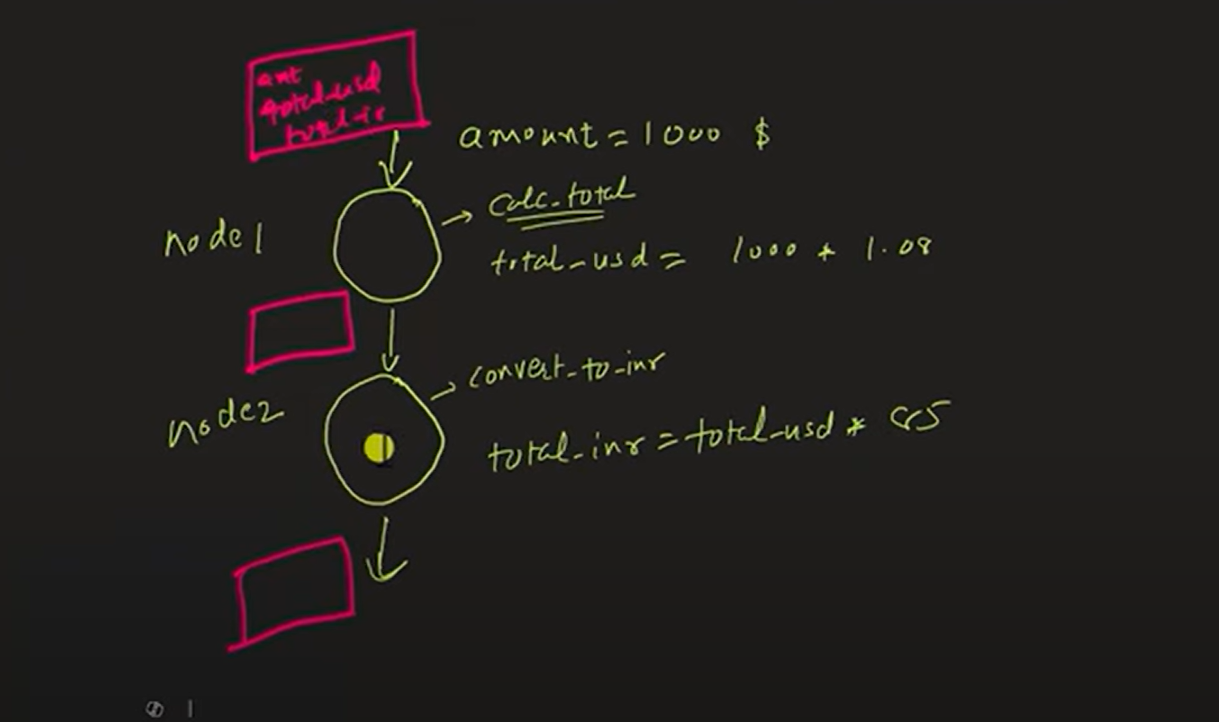

In Python, **TypedDict** is a feature from the typing module that allows you to define dictionaries with specific key-value types in a more structured and type-safe way.

It helps you declare the expected structure of a dictionary — what keys it should have, and what type of values each key should hold. This is especially useful for type checking, code readability, and auto-completion in IDEs.

**State = shared snapshot of application**: It’s a data structure, typically defined with a TypedDict, that holds all relevant information across a graph’s execution—things like conversation messages, counters, flags, or any custom context your nodes need 

**Passed and updated between nodes:** Every node receives the current state, processes it, and returns an updated state dict. The graph then passes that updated state to the next node

In LangGraph, a StateGraph is the core structure that defines your graph-based agent workflow. It’s where you:

Declare the shape of your state (what data is tracked),

Add **nodes** (individual steps or logic),

Define **edges** (how nodes connect and when),

And ultimately compile the graph into a callable program.

## Building Blocks of LangGraph

**1. State** is the central concept in LangGraph. It represents all the information that flows through your application.
    
The state is User defined, hence the fields should carefully be crafted to contain all data needed for decision-making process

In [2]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

**2. Nodes** Nodes are python functions. Each node:

Takes the state as input
Performs some operation
Returns updates to the state

**For example, Nodes can contain:**

**LLM calls**: Generate text or make decisions

**Tool calls**: Interact with external systems

**Conditional logic**: Determine next steps

**Human intervention**: Get input from users

Here we are creating 3 Nodes so that we can use any according to the requirement or use

In [3]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

**3. Edges**
Edges connect nodes and define the possible paths through your graph

Edges can be:

**Direct:** Always go from node A to node B

**Conditional:** Choose the next node based on the current state

In [4]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

Now we have to decide weather to go with node_2 or node_3

**4. StateGraph**
The StateGraph is the container that holds your entire agent workflow:

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()
print(graph)

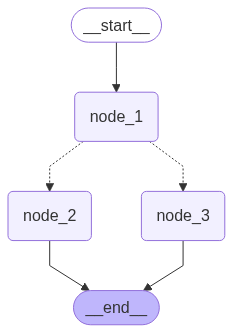

In [6]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 2---


{'graph_state': 'Hi, this is Lance. I am happy!'}

## Now we are making a agent which can convert US Dollar into Indian Rupees.

**State**

In [8]:
from typing import TypedDict

class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    total_inr: float
    

**Edges**

In [9]:
def calc_total(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08
    return state

def convert_to_inr(state: PortfolioState) -> PortfolioState:
    state['total_inr'] = state['total_usd'] * 85
    return state

**StateGraph** 

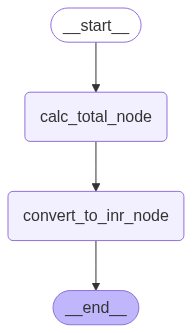

In [10]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(PortfolioState)

builder.add_node("calc_total_node", calc_total)
builder.add_node("convert_to_inr_node", convert_to_inr)

builder.add_edge(START, "calc_total_node")
builder.add_edge("calc_total_node", "convert_to_inr_node")
builder.add_edge("convert_to_inr_node", END)

graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
graph.invoke({"amount_usd": 100000})


{'amount_usd': 100000, 'total_usd': 108000.0, 'total_inr': 9180000.0}